**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [0]:
import tensorflow as tf
#tf.enable_eager_execution()

In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcairo2 libgdk-pixbuf2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libjbig0 libopenjp2-7 libopenslide0 libpixman-1-0 libtiff5 libxcb-render0
  libxcb-shm0 shared-mime-info
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libcairo2 libgdk-pixbuf2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libjbig0 libopenjp2-7 libopenslide0 libpixman-1-0 libtiff5 libxcb-render0
  libxcb-shm0 openslide-tools shared-mime-info
0 upgraded, 13 newly installed, 0 to remove and 5 not upgraded.
Need to get 1,849 kB of archives.
After this operation, 6,727 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 shared-mime-info amd64 1.9-2 [426 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-0 amd64 0.34.0-2 [229 kB]
Get:3 http://archive.ubuntu.c

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [4]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   109M      0  0:00:04  0:00:04 --:--:--  114M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  49.8M      0 --:--:-- --:--:-- --:--:-- 49.8M


In [5]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

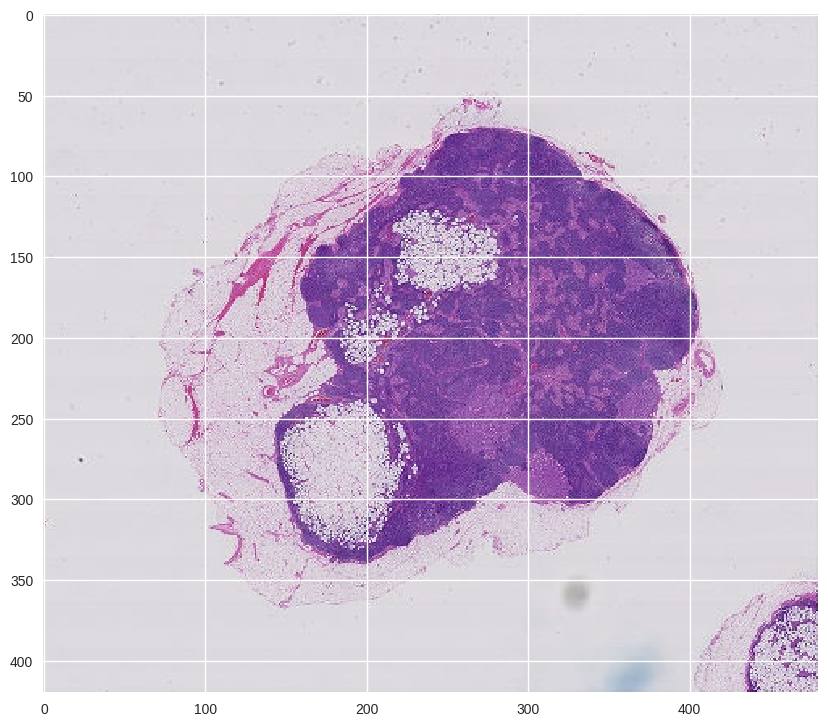

In [7]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

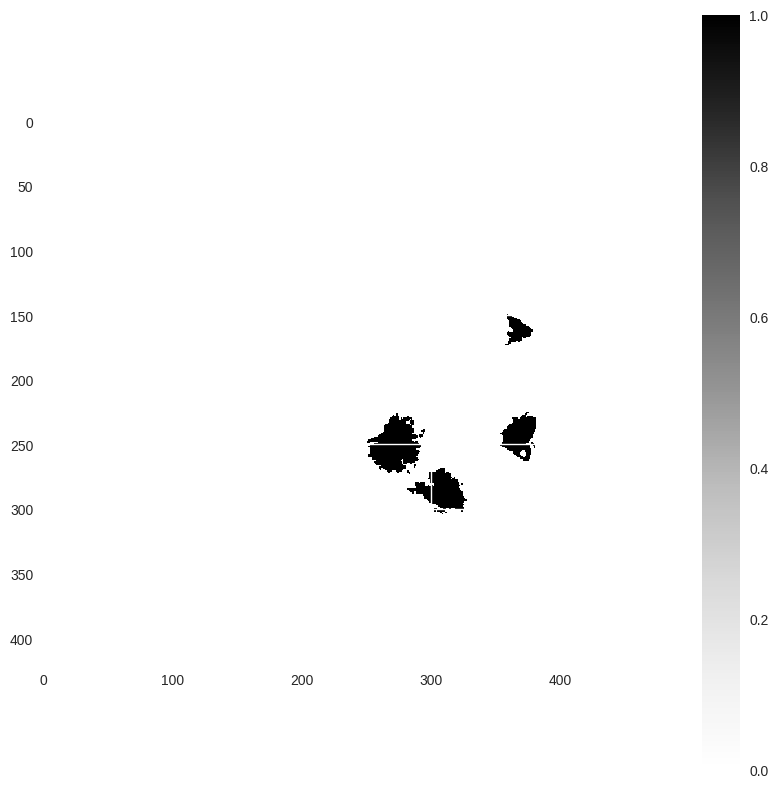

In [8]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)
plt.colorbar()

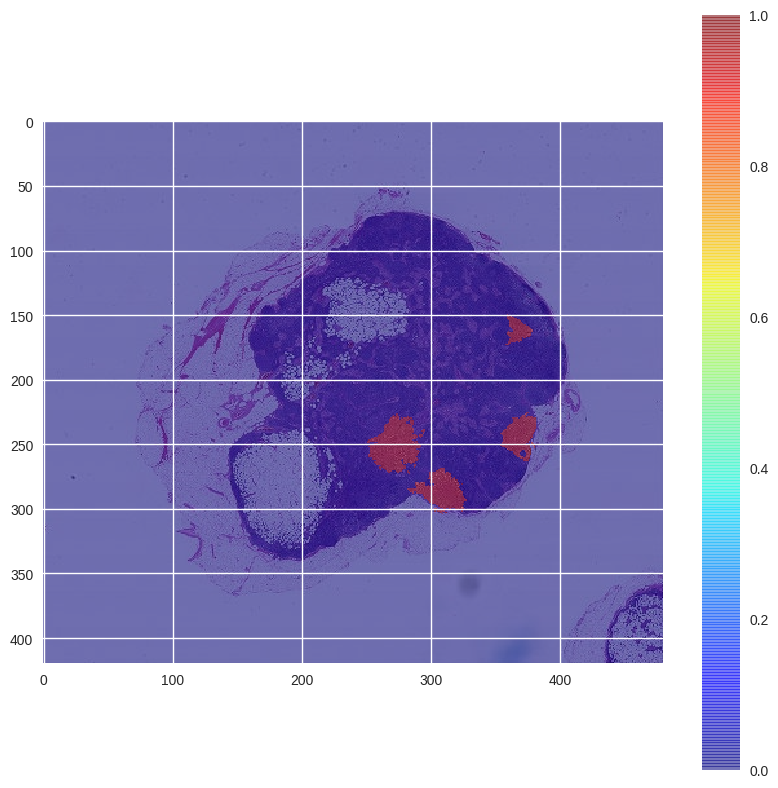

In [9]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.colorbar()

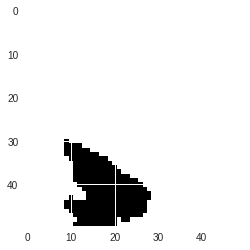

In [10]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,1]
plt.imshow(region)

In [0]:
%%time
#creating samples by sliding through the windows



#w = slide.level_dimensions[7][0]/10
#h = slide.level_dimensions[7][1]/10

#y_lim = slide.level_dimensions[0][1]
#x_lim = slide.level_dimensions[0][0]

#regions = list()
#targets = list()

#x_coord = 0
#y_coord = 0
#j = 0
#c = 1

#while y_coord < y_lim:
#  i = 0
#  x_coord = 0
#  
#  while x_coord < x_lim:
#    region_sample = read_slide(slide, x = x_coord, y = y_coord, level = 7, width = w, height = h)
#    region_tumor = read_slide(tumor_mask, x = x_coord, y = y_coord, level = 7, width = w, height = h)[:,:,1]
#    regions.append(region_sample)
#    targets.append(region_tumor)
    #print("sample %d added, %d x_coord, %d y_coord" % (c, x_coord, y_coord))
#    i += 1
#    c += 1
#    x_coord = 0 + i*w*128
   
    
#  j += 1
#  y_coord = 0 + j*h*128
#print("%d samples added" % (c))

101 samples added
CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 40.1 ms


In [0]:
#from skimage.transform import resize

def slidingwindow(slide, w, h, window_size):
  return slide[w:w+window_size, h:h+window_size]


def generatingdataset(slide, slide2, step_size, window_size):
  w = 0
  h = 0
  dataset = list()
  target = list()
  for j in range((slide2.shape[1]-window_size)/step_size):
    for i in range((slide2.shape[0]-window_size)/step_size):
      dataset.append(slidingwindow(slide, w + i*step_size, h + j*step_size, window_size))
      target.append(slidingwindow(slide2, w + j*step_size, h + j*step_size, window_size))
      
  return np.array(dataset), np.array(target)

In [58]:
%%time
X, y = generatingdataset(slide_image, mask_image, 4, 50)
print(X.shape, y.shape)

((9844, 50, 50, 3), (9844,))
CPU times: user 54.9 ms, sys: 32.3 ms, total: 87.2 ms
Wall time: 85.9 ms


In [0]:
y_label = []
for target in y:
  if target.sum() > 1:
    y_label += [1]
  else:
    y_label += [0]

In [60]:
len(y_label)

9844

In [0]:
xception = tf.keras.applications.vgg19.VGG19(input_shape = (50,50,3), include_top = False,
                                         weights = 'imagenet')
xception.trainable = False

In [0]:
model = tf.keras.Sequential([
  xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation = 'relu'),
 # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(len(np.unique(y_label)), activation = 'softmax')])

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 20,057,346
Trainable params: 32,962
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [66]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y_label, random_state = 0)
print(len(X_train), len(y_train))
#print(X_test, y_test)


(7383, 7383)


In [70]:
model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.1)

Train on 6644 samples, validate on 739 samples
Epoch 1/5
6644/6644 [==============================] - 239s 36ms/step - loss: 0.4248 - acc: 0.8840 - val_loss: 0.1734 - val_acc: 0.9323
Epoch 2/5
6644/6644 [==============================] - 243s 37ms/step - loss: 0.2066 - acc: 0.9327 - val_loss: 0.1545 - val_acc: 0.9459
Epoch 3/5
6644/6644 [==============================] - 241s 36ms/step - loss: 0.1448 - acc: 0.9532 - val_loss: 0.1584 - val_acc: 0.9459
Epoch 4/5
6644/6644 [==============================] - 241s 36ms/step - loss: 0.1186 - acc: 0.9597 - val_loss: 0.1338 - val_acc: 0.9445
Epoch 5/5
6644/6644 [==============================] - 241s 36ms/step - loss: 0.1059 - acc: 0.9657 - val_loss: 0.1377 - val_acc: 0.9540


In [71]:
print("The test score is: ", model.evaluate(X_test, y_test))

2461/2461 [==============================] - 80s 33ms/step
('The test score is: ', [0.17031538358721873, 0.9496139783241166])


In [85]:
y_pred = model.predict(X_test)
y_pred

array([[9.9969053e-01, 3.0945567e-04],
       [8.5459816e-01, 1.4540191e-01],
       [6.2120434e-02, 9.3787962e-01],
       ...,
       [9.9999166e-01, 8.3130180e-06],
       [6.8950176e-01, 3.1049827e-01],
       [1.0000000e+00, 4.4407199e-18]], dtype=float32)

In [86]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

y_predict_label = y_pred.argmax(axis = 1)

print('Recall: ', recall_score(y_test, y_predict_label))
print('F1: ', f1_score(y_test, y_predict_label))
print('Precision: ', precision_score(y_test, y_predict_label))

('Recall: ', 0.8890814558058926)
('F1: ', 0.8921739130434783)
('Precision: ', 0.8952879581151832)


62589 tissue_pixels pixels (35.5 percent of the image)


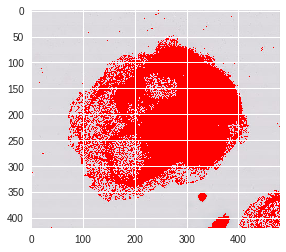

In [87]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)